In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc 
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
data = pd.read_csv('/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv')

In [3]:
# Display the first few rows of the dataset
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
# Statistical summary of numerical fields
stats_summary = data.describe()

# Data types of each column
data_types = data.dtypes

# Checking for missing values
missing_values = data.isnull().sum()

stats_summary, data_types, missing_values

(         person_age  person_income  person_emp_length     loan_amnt  \
 count  32581.000000   3.258100e+04       31686.000000  32581.000000   
 mean      27.734600   6.607485e+04           4.789686   9589.371106   
 std        6.348078   6.198312e+04           4.142630   6322.086646   
 min       20.000000   4.000000e+03           0.000000    500.000000   
 25%       23.000000   3.850000e+04           2.000000   5000.000000   
 50%       26.000000   5.500000e+04           4.000000   8000.000000   
 75%       30.000000   7.920000e+04           7.000000  12200.000000   
 max      144.000000   6.000000e+06         123.000000  35000.000000   
 
        loan_int_rate   loan_status  loan_percent_income  \
 count   29465.000000  32581.000000         32581.000000   
 mean       11.011695      0.218164             0.170203   
 std         3.240459      0.413006             0.106782   
 min         5.420000      0.000000             0.000000   
 25%         7.900000      0.000000             0.

In [6]:
# Adjust employment length where it is not plausible
def adjust_employment_length(row):
    max_possible_length = max(0, row['person_age'] - 14)
    if row['person_emp_length'] > max_possible_length:
        return None  # Set implausible values to None for median calculation
    else:
        return row['person_emp_length']

# Apply the adjustment function
data['person_emp_length'] = data.apply(adjust_employment_length, axis=1)

In [7]:
# Apply the adjustment function
data['person_emp_length'] = data.apply(adjust_employment_length, axis=1)

# Step 2: Create age groups
data['age_group'] = pd.cut(data['person_age'], bins=range(10, 101, 10), right=False, labels=[f"{i}-{i+9}" for i in range(10, 91, 10)])

# Step 3: Calculate median employment length for each age group
group_median = data.groupby('age_group', observed=True)['person_emp_length'].transform('median')

# Step 4: Impute missing or adjusted values using the group-specific median
data['person_emp_length'] = data['person_emp_length'].fillna(group_median)

In [8]:
# Handling outliers
data['person_age'] = data['person_age'].clip(lower=14)

# Calculate the median outside of the fillna operation
median_int_rate = data['loan_int_rate'].median()

# Apply the fillna method directly using the calculated medians
data['loan_int_rate'] = data['loan_int_rate'].fillna(median_int_rate)

In [9]:
# Statistical summary of numerical fields
stats_summary = data.describe()

# Checking for missing values
missing_values = data.isnull().sum()

stats_summary, missing_values

(         person_age  person_income  person_emp_length     loan_amnt  \
 count  32581.000000   3.258100e+04       32581.000000  32581.000000   
 mean      27.734600   6.607485e+04           4.760597   9589.371106   
 std        6.348078   6.198312e+04           3.981066   6322.086646   
 min       20.000000   4.000000e+03           0.000000    500.000000   
 25%       23.000000   3.850000e+04           2.000000   5000.000000   
 50%       26.000000   5.500000e+04           4.000000   8000.000000   
 75%       30.000000   7.920000e+04           7.000000  12200.000000   
 max      144.000000   6.000000e+06          41.000000  35000.000000   
 
        loan_int_rate   loan_status  loan_percent_income  \
 count   32581.000000  32581.000000         32581.000000   
 mean       11.009620      0.218164             0.170203   
 std         3.081611      0.413006             0.106782   
 min         5.420000      0.000000             0.000000   
 25%         8.490000      0.000000             0.

In [10]:
data = data.drop('age_group',axis=1)

In [13]:
# 'Default (loan_status)' is the target variable and it's a binary column
X = data.drop('loan_status', axis=1)  # features
y = data['loan_status']  # target variable

# Convert categorical variables to dummy variables
X = pd.get_dummies(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Fit the model
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [17]:
# Predictions
predictions = model.predict(X_test)

# Evaluation
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      5072
           1       0.71      0.15      0.25      1445

    accuracy                           0.80      6517
   macro avg       0.76      0.57      0.57      6517
weighted avg       0.78      0.80      0.74      6517

Accuracy: 0.7983734847322388


In [18]:
# Initialize the model with adjusted class weights
model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Fit the model on the training data
model.fit(X_train, y_train)

# Predictions on the test set and evaluation
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))
print("Accuracy:", accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.92      0.67      0.77      5072
           1       0.40      0.79      0.53      1445

    accuracy                           0.69      6517
   macro avg       0.66      0.73      0.65      6517
weighted avg       0.80      0.69      0.72      6517

Accuracy: 0.692496547491177


In [19]:
# Predict probabilities for the test data
probabilities = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

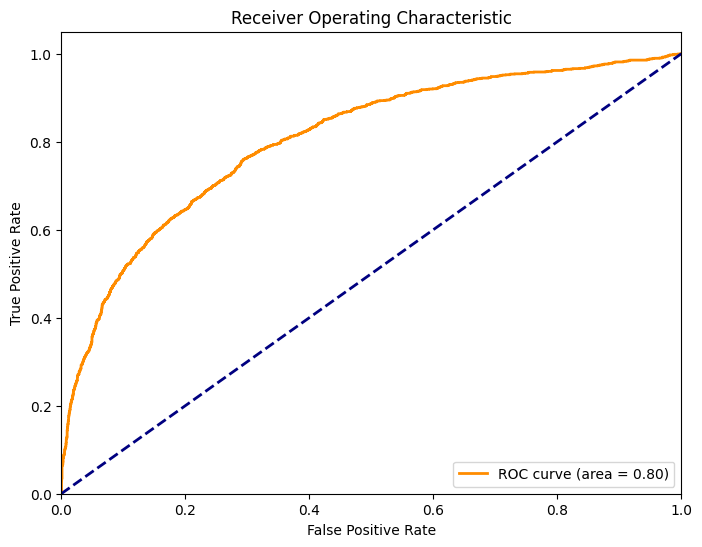

In [21]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

                           Feature  Importance
4                    loan_int_rate    0.175910
2                person_emp_length   -0.038704
0                       person_age   -0.031618
20                    loan_grade_D    0.019499
6       cb_person_cred_hist_length   -0.019085
10      person_home_ownership_RENT    0.016355
17                    loan_grade_A   -0.015870
25     cb_person_default_on_file_Y    0.012917
24     cb_person_default_on_file_N   -0.012791
7   person_home_ownership_MORTGAGE   -0.010195
18                    loan_grade_B   -0.009601
16             loan_intent_VENTURE   -0.006249
9        person_home_ownership_OWN   -0.006125
11   loan_intent_DEBTCONSOLIDATION    0.005787
21                    loan_grade_E    0.005606
12           loan_intent_EDUCATION   -0.004117
14             loan_intent_MEDICAL    0.003069
13     loan_intent_HOMEIMPROVEMENT    0.002996
5              loan_percent_income    0.002037
19                    loan_grade_C   -0.001789
22           

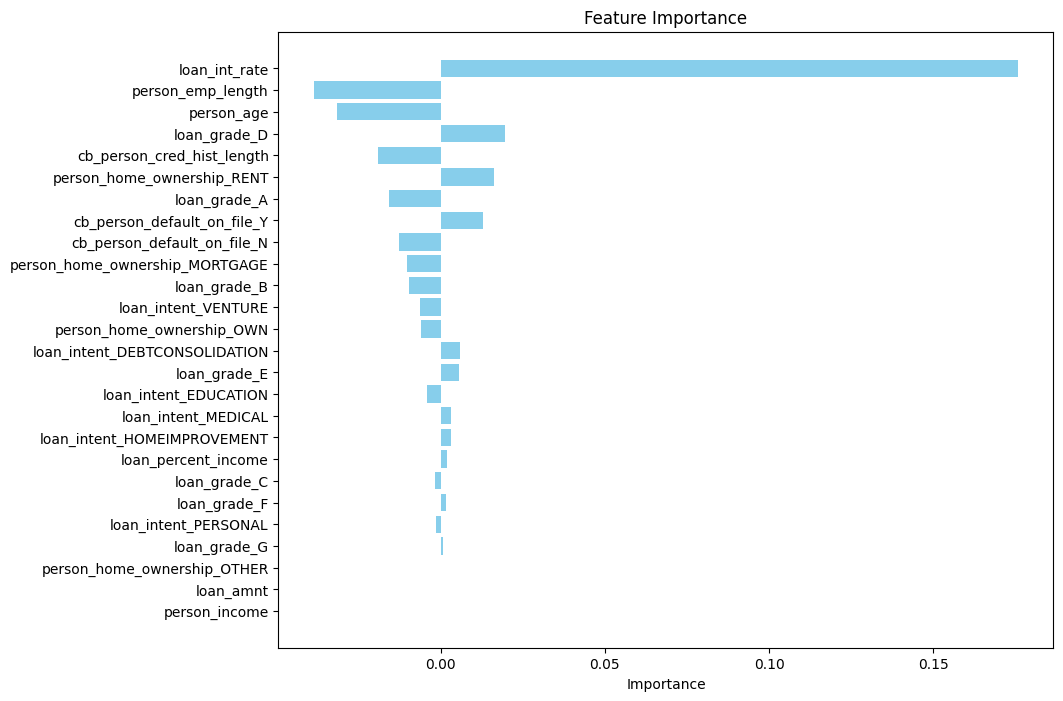

In [22]:
# Sorting by the absolute values
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.coef_[0]
}).sort_values(by='Importance', key=abs, ascending=False)

# Display the DataFrame
print(feature_importance)

# Plotting feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [24]:
# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Average CV Accuracy:", cv_scores.mean())

Cross-validation scores: [0.51802977 0.63244322 0.70595457 0.72130141 0.76335175]
Average CV Accuracy: 0.6682161439604574


In [25]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define the stratified k-fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
print("Stratified Cross-validation scores:", cv_scores)
print("Average Stratified CV Accuracy:", cv_scores.mean())

Stratified Cross-validation scores: [0.6923431  0.68692449 0.68815224 0.71485574 0.72483118]
Average Stratified CV Accuracy: 0.7014213522681813


In [26]:
data.to_csv('credit_risk_dataset_cleaned.csv', index = False)